# Sigma


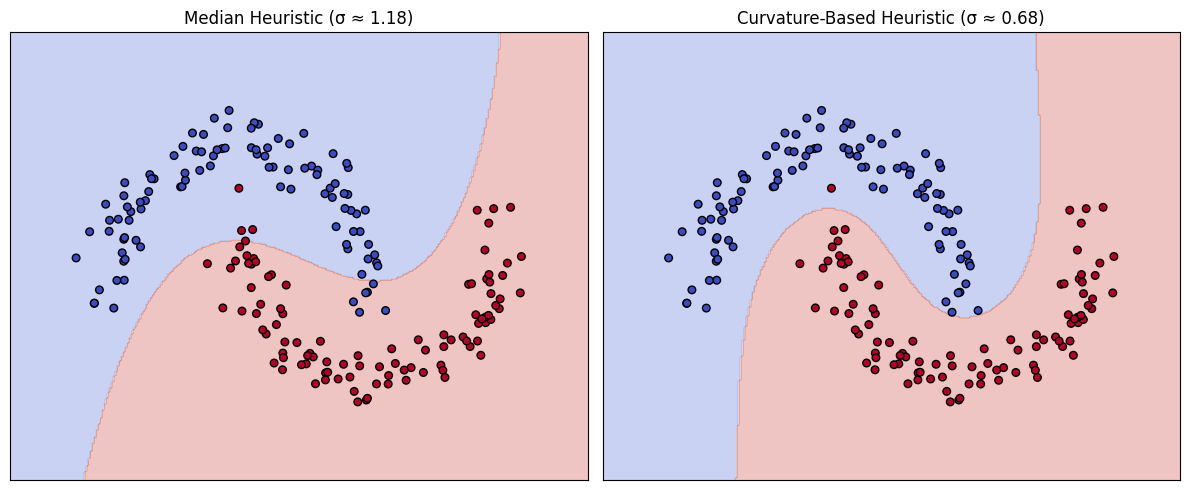

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.svm import SVC

# Step 1: Generate two-moon dataset
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

# Step 2: Compute pairwise squared distances
dists = pairwise_distances(X, metric='euclidean')
upper_tri = np.triu_indices_from(dists, k=1)
d2 = dists[upper_tri] ** 2
median_d2 = np.median(d2)
median_d = np.sqrt(median_d2)

# Step 3: Compute sigma and gamma for both heuristics

# Median Heuristic
sigma_median = median_d
gamma_median = 1 / (2 * sigma_median**2)

# Curvature-Based Heuristic
sigma_curvature = np.sqrt(median_d2 / 3)
gamma_curvature = 1 / (2 * sigma_curvature**2)

# Step 4: Train RBF SVM models
svm_median = SVC(kernel='rbf', gamma=gamma_median)
svm_curvature = SVC(kernel='rbf', gamma=gamma_curvature)
svm_median.fit(X, y)
svm_curvature.fit(X, y)

# Step 5: Function to plot decision boundary
def plot_decision_boundary(clf, X, y, title, ax):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=30)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Step 6: Plot the decision boundaries
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_decision_boundary(svm_median, X, y, f"Median Heuristic (σ ≈ {sigma_median:.2f})", axs[0])
plot_decision_boundary(svm_curvature, X, y, f"Curvature-Based Heuristic (σ ≈ {sigma_curvature:.2f})", axs[1])

plt.tight_layout()
plt.show()


f1 score for median approach 0.8651685393258427
f1 score for curvature approach 0.8888888888888888


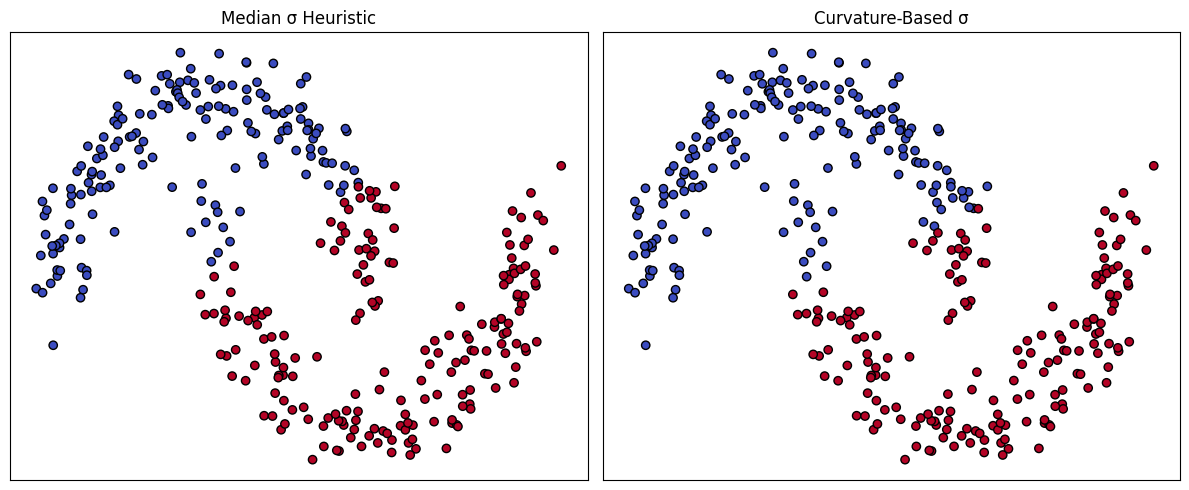

In [ ]:
import numpy as np
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPS = 1e-10

# Your functions
def guassian(X, use_curvature=False):
    dist_sq = torch.cdist(X, X) ** 2
    dists_np = dist_sq.detach().cpu().numpy()
    median_sq_dist = np.median(dists_np[np.triu_indices_from(dists_np, k=1)])

    if use_curvature:
        sigma = np.sqrt(median_sq_dist / 3)
    else:
        sigma = np.sqrt(median_sq_dist)

    W = torch.exp(-dist_sq / (2 * sigma ** 2))
    return W

def normalize_adj(adj):
    D = torch.sum(adj, dim=1)
    D_inv_sqrt = torch.pow(D + EPS, -0.5)
    D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.
    return D_inv_sqrt.unsqueeze(1) * adj * D_inv_sqrt.unsqueeze(0)

def lpa(train_emb, test_emb, Ytrain, num_labels, use_curvature=False):
    emb = torch.cat((train_emb, test_emb), dim=0)
    num_nodes = emb.shape[0]
    labels = torch.cat((Ytrain, torch.zeros(test_emb.shape[0], device=device)), dim=0)

    Y = torch.zeros((num_nodes, num_labels), dtype=torch.float).to(device)
    for k in range(num_labels):
        Y[labels == k, k] = 1

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[:Ytrain.shape[0]] = 1
    test_mask = ~train_mask

    adj = guassian(emb, use_curvature)
    adj = adj + adj.t()
    adj = normalize_adj(adj)
    adj = adj.to_dense()

    F = torch.zeros_like(Y, dtype=torch.float)
    F[train_mask] = Y[train_mask]
    F[test_mask] = 0

    N_l = train_emb.shape[0]
    adj_ul = adj[N_l:, :N_l]
    adj_uu = adj[N_l:, N_l:]

    I = torch.eye(adj_uu.shape[0], dtype=torch.float, device=device)
    rhs = torch.matmul(adj_ul, F[train_mask])
    F_UU = torch.linalg.solve(I - adj_uu, rhs)

    F_UU = F_UU.real + EPS
    F_UU /= torch.sum(F_UU, axis=1, keepdims=True)
    return F_UU

# Prepare data
X, y = make_moons(n_samples=700, noise=0.1, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert to torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# Apply LPA with both heuristics
pred_median = lpa(X_train_tensor, X_test_tensor, y_train_tensor, num_labels=2, use_curvature=False)
pred_curvature = lpa(X_train_tensor, X_test_tensor, y_train_tensor, num_labels=2, use_curvature=True)

# Convert predictions to labels
labels_median = pred_median.argmax(dim=1).cpu().numpy()
print('f1 score for median approach', f1_score(y_test, labels_median))
labels_curvature = pred_curvature.argmax(dim=1).cpu().numpy()
print("f1 score for curvature approach", f1_score(y_test, labels_curvature))

# Plotting
def plot_lpa_results(X_test, y_test, preds, title, ax):
    ax.scatter(X_test[:, 0], X_test[:, 1], c=preds, cmap='coolwarm', edgecolors='k')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_lpa_results(X_test, y_test, labels_median, "Median σ Heuristic", axs[0])
plot_lpa_results(X_test, y_test, labels_curvature, "Curvature-Based σ", axs[1])
plt.tight_layout()
plt.show()


Dataset: F1-score = 0.8102592388306674


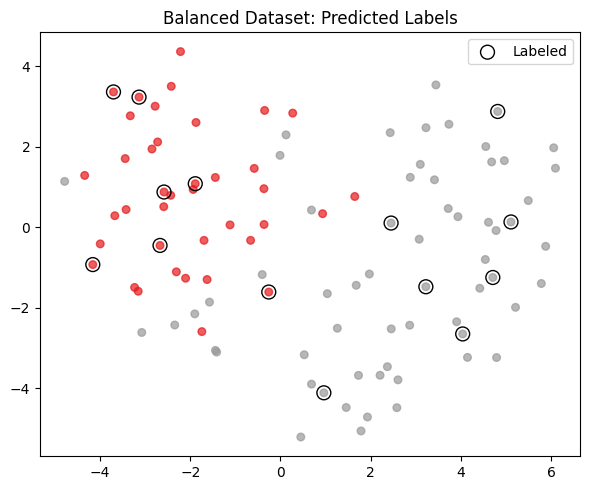

Dataset: F1-score = 0.5252653927813163


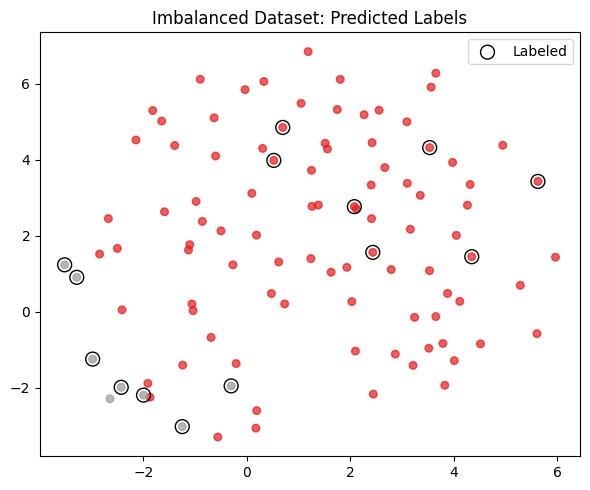

In [1]:
import torch
import numpy as np
from sklearn.datasets import make_classification
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances, f1_score
import torch.nn.functional as F

EPS = 1e-12
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

def guassian(X):
    dist_sq = torch.cdist(X, X) ** 2
    dists_np = dist_sq.detach().cpu().numpy()
    median_sq_dist = np.median(dists_np[np.triu_indices_from(dists_np, k=1)])
    # sigma = np.sqrt(median_sq_dist/3)
    sigma = median_sq_dist
    W = torch.exp(-dist_sq / (2 * sigma ** 2))
    return W

def normalize_adj(adj):
    D = torch.sum(adj, dim=1)
    D_inv_sqrt = torch.pow(D + EPS, -0.5)
    D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.
    return D_inv_sqrt.unsqueeze(1) * adj * D_inv_sqrt.unsqueeze(0)

def lpa(train_emb, test_emb, Ytrain, num_labels):
    emb = torch.cat((train_emb, test_emb), dim=0)
    num_nodes = emb.shape[0]
    labels = torch.cat((Ytrain, torch.zeros(test_emb.shape[0], device=device)), dim=0)

    Y = torch.zeros((num_nodes, num_labels), dtype=torch.float).to(device)
    for k in range(num_labels):
        Y[labels == k, k] = 1

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[:Ytrain.shape[0]] = 1
    test_mask = ~train_mask

    adj = guassian(emb)
    adj = adj + adj.t()
    adj = normalize_adj(adj)
    adj = adj.to_dense()

    F = torch.zeros_like(Y, dtype=torch.float)
    F[train_mask] = Y[train_mask]
    F[test_mask] = 0

    N_l = train_emb.shape[0]
    adj_ul = adj[N_l:, :N_l]
    adj_uu = adj[N_l:, N_l:]

    I = torch.eye(adj_uu.shape[0], dtype=torch.float)
    rhs = torch.matmul(adj_ul, F[train_mask])
    F_UU = torch.linalg.solve(I - adj_uu, rhs)

    F_UU = F_UU.real + EPS
    F_UU /= torch.sum(F_UU, axis=1, keepdims=True)
    return F_UU

def plot_results(X, y_true, pred_labels, labeled_indices, title):
    X_2d = TSNE(n_components=2, random_state=42).fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pred_labels, cmap='Set1', s=30, alpha=0.7)
    plt.scatter(X_2d[labeled_indices, 0], X_2d[labeled_indices, 1],
                c='none', edgecolors='black', marker='o', s=100, label='Labeled')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Run on Two Datasets ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for dataset_type, weights in zip(["Balanced", "Imbalanced"], [[0.5, 0.5], [0.8, 0.2]]):
    X, y = make_classification(n_samples=100, n_features=20, n_informative=10,
                               n_redundant=0, weights=weights,
                               n_clusters_per_class=1, random_state=42)

    num_classes = len(np.unique(y))
    labeled_indices = []
    for c in range(num_classes):
        idx = np.where(y == c)[0]
        labeled_indices.extend(np.random.choice(idx, 7, replace=False))
    labeled_indices = np.array(labeled_indices)

    test_indices = np.array([i for i in range(len(y)) if i not in labeled_indices])
    Ytrain = torch.tensor(y[labeled_indices], dtype=torch.long).to(device)
    train_emb = torch.tensor(X[labeled_indices], dtype=torch.float32).to(device)
    test_emb = torch.tensor(X[test_indices], dtype=torch.float32).to(device)

    pred_soft = lpa(train_emb, test_emb, Ytrain, num_classes)
    pred_labels = pred_soft.argmax(dim=1).cpu().numpy()

    y_true_test = y[test_indices]
    full_pred = np.copy(y)
    full_pred[test_indices] = pred_labels
    print(f"Dataset: F1-score = {f1_score(y_true_test, pred_labels, average='macro')}")
    plot_results(X, y, full_pred, labeled_indices, f"{dataset_type} Dataset: Predicted Labels")